In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch
import torch.nn as nn

## TO DO

1. Define SGD function
2. Define Newton's function
3. Define Quasi-Newton's method
4. Write simulation function (in-progress; BP)
5. Write simulation comparison code / Post Processing (in-progress; BP)

## FINISHED
1. Write data generating function
2. Write Normal Equation function (theoretical)

## Functions

SGD
epoch 0, loss 0.3222438395023346
epoch 50, loss 0.12302440404891968
epoch 100, loss 0.08293069154024124
epoch 150, loss 0.07239807397127151
epoch 200, loss 0.06963115930557251
epoch 250, loss 0.06890428811311722
epoch 300, loss 0.06871334463357925
epoch 350, loss 0.06866317242383957
epoch 400, loss 0.06864999979734421
epoch 450, loss 0.06864653527736664

predicted :  2.0158765
true      :  2


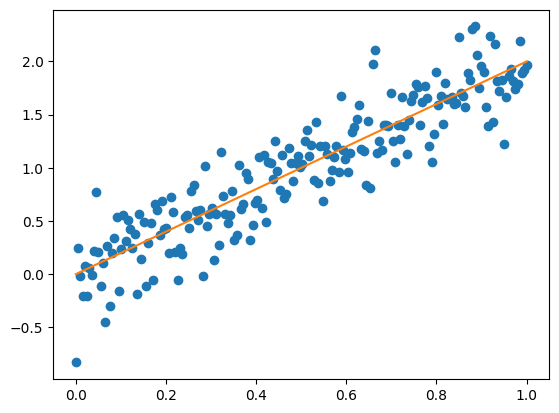

In [2]:
#CREATE SIMULATION DATA
# creates feature matrix and corresponding observation.
# y - n x 1 matrix of normal distribution data of mu and sigma
# X - n x m matrix of parameters. First column is the intercept which is always 1
# Each parameter (column) is from the normal distribution of mu and sigma
# default is std norm: mu = 0, sd = 1

def create_sim_data_lr(n,m,mu = 0, sigma = 1):
    y = np.random.normal(mu,sigma,size = (n,1))    
    X = np.random.normal(mu,sigma,size = (n,m))
    X[:,0] = 1
    
    return ((X,y))

### Normal Equation (Theoretical)
# Closed Form Solution
# beta_hat = (X^T %*% X)^-1 %*% X %*% y
def normal_eq_lr(X,y):
    A = np.linalg.inv(np.matmul(np.transpose(X),X))
    B = np.matmul(np.transpose(X),y)
    return(np.matmul(A,B))


def sim_linear(n_points, b1, noise_std):
    """Simulate a linear regression problem.
    
    Parameters
    ----------
    n_points : int
        Number of simulated points per observation.
    b1 : float
        Slope to predict.
    noise_std : float
        Width of Guassian (white) noise.
        
    Returns
    -------
    X : 1d array
        Randomly sampled x-values.
    y : 1d array
        Y-values with added white noise.
    """
    
    X = np.linspace(0, 1, n_points)
    noise = np.random.normal(0, noise_std, n_points)
    y = b1*X + noise
    
    return X, y


# Simulate
b1 = 2
X, y = sim_linear(200, b1, .25)

plt.scatter(X, y)
plt.plot(X, b1 * X, color='C1')

X = X.reshape(-1, 1).astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

# Linear regression
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
    
### SGD
print('SGD')
model = LinearRegression()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(500):
 
    y_hat = model(X)
 
    # Compute loss
    loss = criterion(y_hat, y)
 
    # Zero gradients
    optimizer.zero_grad()
    
    # Backpropaget and update weights
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
print()       
print('predicted : ', model.linear.weight.detach().numpy()[0][0])
print('true      : ', 2)
    
### Newton's

### Quasi-Newton


## Simulations

The goal of these simulations is to create cases where we have n samples (could be low or high) and m features (1-1000). In the context of an optimization problem, compare the performance between SGD, Newton's method, and Quasi-Newton for each case.

Optimization problems to try: Regression, Classification (maybe if we don't have time, we can stick to regression only)

In [37]:
nsim = 1000 # number of simulations
m = 1000 # number of features
n = 10000 # number of observations
np.random.seed(123) # set seed for reproducibility

res = {'normal-eq': dict(), 'sgd': dict(),'newton': dict(),'quasi-newton':dict()} # Store betas for each method here
res_time = {'normal-eq': dict(), 'sgd': dict(),'newton': dict(),'quasi-newton':dict()} # Store runtimes for each method here
for i in tqdm(range(nsim)):
    data = create_sim_data_lr(n,m) # for each iteration, generate new data
    
    ### Expected: beta_m parameters in a list
    
    # DO theoretical soln:
    # beta_hat = (X^T %*% X)^-1 %*% X %*% y
    # This solution might not be available...
    try:
        start = time.time()
        res['normal-eq'][i] = normal_eq_lr(data[0],data[1])[:,0].tolist()
        end = time.time()
        res_time['normal-eq'][i] = end-start # records the time elapsed to calculate
    except:
        res['normal-eq'][i] = 'Did not compute'
        res_time['normal-eq'][i] = 'NA'
    
    
    # DO SGD
    #res['sgd'][i] = 
    # DO NEWTON'S
    #res['newton'][i] = 
    # DO QUASI NEWTON'S
    #res['quasi-newton'][i] = 
    
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
### VISUALIZATION FUNCTIONS TO COMPARE SIMULATION TIMES AS WELL AS BETAS FOR EACH METHOD
dfs = []
normal_eq_times = pd.DataFrame.from_dict(res_time['normal-eq'], orient='index')
normal_eq_betas = pd.DataFrame.from_dict(res['normal-eq']) # Each column is a simulation, Each row is a beta
#normal_eq_betas_vals = normal_eq_betas
normal_eq_beta_hats = normal_eq_betas.mean(axis=1)
normal_eq_beta_sds = normal_eq_betas.std(axis=1)

normal_eq_betas['beta_hat'] = normal_eq_beta_hats
normal_eq_betas['sd'] = normal_eq_beta_sds
#sgd_times = pd.DataFrame.from_dict(res_time['sgd'], orient='index')
#newton_times = pd.DataFrame.from_dict(res_time['newton'], orient='index')
#quasi_newton_times = pd.DataFrame.from_dict(res_time['quasi-newton'], orient='index')
#dfs.append(normal_eq_times,sgd_times,newton_times,quasi_newton_times)

#dfs = pd.concat(dfs,axis = 1) # combines all the times together into one matrix for easy computation
# get the mean time and sd for each method and plot in a violin plot? similar to what I showed in the midterm presentation


# X axis is betas
# Y axis is value

# overlay methods ontop of each other in different colors